In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns


# Load and Preprocess Data 

In [92]:
df = pd.read_csv('balanced_dataset.csv')

# Modify labels: 0 -> 1, others (1,2,3,4) -> 0
df['label'] = df['label'].apply(lambda x: 1 if x == 0 else 0)

# Preprocess data
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['label']))
y = df['label'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# ANFIS Model

In [93]:
class ANFIS(nn.Module):
    def __init__(self, input_dim, num_rules):
        super(ANFIS, self).__init__()
        self.num_rules = num_rules
        
        # Fuzzy Membership Parameters (Gaussian functions) - Ensuring Stability
        self.mu = nn.Parameter(torch.randn(input_dim, num_rules))
        self.sigma = nn.Parameter(torch.randn(input_dim, num_rules).abs() + 1e-6)  # Avoiding zero sigma
        
        # Output Layer
        self.linear = nn.Linear(num_rules, 1)  # Single output for binary classification
    
    def forward(self, x):
        # Gaussian Membership Functions - Adding Stability
        membership = torch.exp(-((x.unsqueeze(2) - self.mu) ** 2) / (2 * self.sigma ** 2 + 1e-6))
        
        # Rule Activation (Product of Memberships)
        rule_activation = torch.prod(membership, dim=1)
        
        # Normalize Rule Activations - Prevent Division by Zero
        sum_activation = torch.sum(rule_activation, dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        rule_strengths = rule_activation / sum_activation
        
        # Weighted Rule Outputs
        output = self.linear(rule_strengths)
        
        return torch.sigmoid(output).squeeze()  # Apply sigmoid for binary classification

# Initialize model
input_dim = X_train.shape[1]
num_rules = 5  # Number of fuzzy rules
model = ANFIS(input_dim, num_rules)


# training

In [102]:
class_weight = torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])])
criterion = nn.BCELoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000  # Increase training epochs for better convergence
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)  # Use adjusted loss function
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/10000], Loss: 1.7463
Epoch [20/10000], Loss: 1.7168
Epoch [30/10000], Loss: 1.7097
Epoch [40/10000], Loss: 1.7084
Epoch [50/10000], Loss: 1.7093
Epoch [60/10000], Loss: 1.7083
Epoch [70/10000], Loss: 1.7083
Epoch [80/10000], Loss: 1.7081
Epoch [90/10000], Loss: 1.7081
Epoch [100/10000], Loss: 1.7081
Epoch [110/10000], Loss: 1.7080
Epoch [120/10000], Loss: 1.7080
Epoch [130/10000], Loss: 1.7080
Epoch [140/10000], Loss: 1.7080
Epoch [150/10000], Loss: 1.7080
Epoch [160/10000], Loss: 1.7080
Epoch [170/10000], Loss: 1.7080
Epoch [180/10000], Loss: 1.7080
Epoch [190/10000], Loss: 1.7080
Epoch [200/10000], Loss: 1.7080
Epoch [210/10000], Loss: 1.7080
Epoch [220/10000], Loss: 1.7080
Epoch [230/10000], Loss: 1.7080
Epoch [240/10000], Loss: 1.7080
Epoch [250/10000], Loss: 1.7080
Epoch [260/10000], Loss: 1.7080
Epoch [270/10000], Loss: 1.7080
Epoch [280/10000], Loss: 1.7080
Epoch [290/10000], Loss: 1.7080
Epoch [300/10000], Loss: 1.7080
Epoch [310/10000], Loss: 1.7080
Epoch [320/10000]

Test Loss: 1.6315
Precision: 0.7941
Confusion Matrix:
[[421   7]
 [ 25  27]]


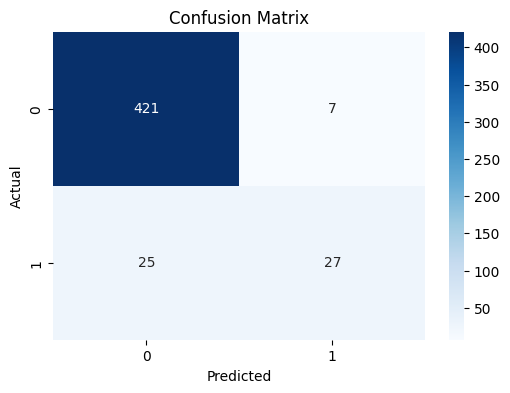

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       428
         1.0       0.79      0.52      0.63        52

    accuracy                           0.93       480
   macro avg       0.87      0.75      0.80       480
weighted avg       0.93      0.93      0.93       480



In [103]:
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert predictions to binary labels
y_pred_class = (y_pred > 0.5).int().numpy()
y_test_numpy = y_test.numpy()

# Calculate precision
precision = precision_score(y_test_numpy, y_pred_class, average='binary', zero_division=1)
print(f'Precision: {precision:.4f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_numpy, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_numpy, y_pred_class, zero_division=1))

# Testing

In [96]:
def test_model(sample_input):
    sample_input = torch.tensor(sample_input, dtype=torch.float32)
    with torch.no_grad():
        prediction = model(sample_input)
        predicted_class = (prediction > 0.5).int().numpy()
    return predicted_class

# Example Test Case
test_sample = X_test[:5]  # Taking first 5 test samples
predictions = test_model(test_sample)
print("Sample Predictions:", predictions)


Sample Predictions: [0 1 0 1 1]


/tmp/ipykernel_34881/624665946.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_input = torch.tensor(sample_input, dtype=torch.float32)


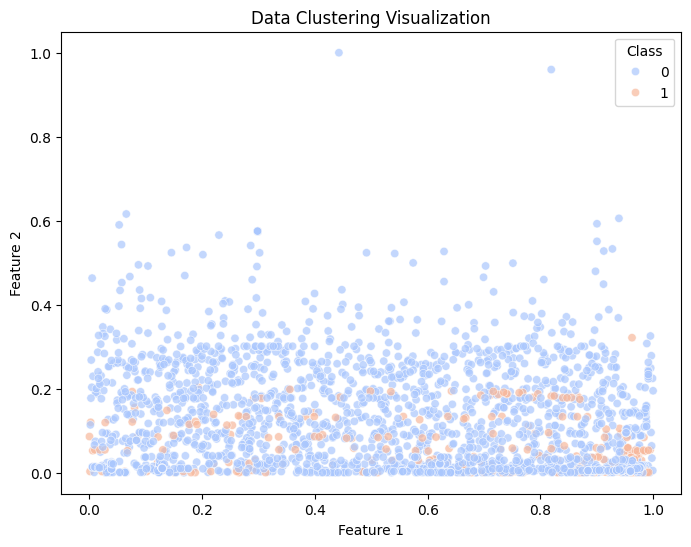

In [97]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Clustering Visualization')
plt.legend(title='Class')
plt.show()

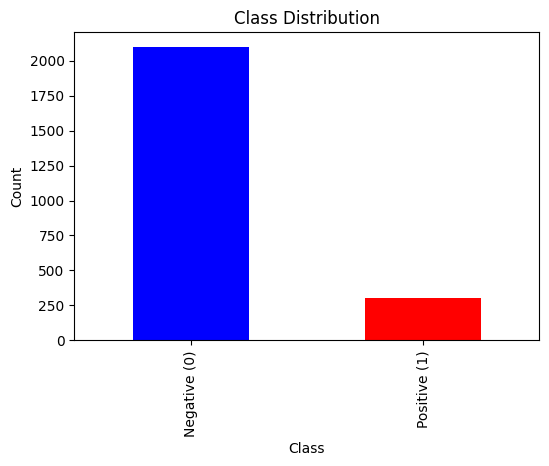

In [98]:
plt.figure(figsize=(6, 4))
class_counts = pd.Series(y).value_counts()
class_counts.plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(ticks=[0, 1], labels=['Negative (0)', 'Positive (1)'])
plt.show()

In [99]:
def test_with_external_data(file_path):
    df_ext = pd.read_csv(file_path)
    df_ext['label'] = df_ext['label'].apply(lambda x: 1 if x == 0 else 0)
    X_ext = scaler.transform(df_ext.drop(columns=['label']))
    y_ext = df_ext['label'].values
    X_ext = torch.tensor(X_ext, dtype=torch.float32)
    y_ext = torch.tensor(y_ext, dtype=torch.float32)
    
    with torch.no_grad():
        y_pred_ext = model(X_ext)
    y_pred_class_ext = (y_pred_ext > 0.5).int().numpy()
    
    print("External Dataset Classification Report:")
    print(classification_report(y_ext.numpy(), y_pred_class_ext, zero_division=1))
    
    # Calculate precision for external dataset
    precision_ext = precision_score(y_ext.numpy(), y_pred_class_ext, average='binary', zero_division=1)
    print(f'External Dataset Precision: {precision_ext:.4f}')
